## 1.Load the Dataset using PySpark

In [58]:
from google.colab import drive
drive.mount('/content/drive')

nodes_path = '/content/drive/MyDrive/Dataset/nodes.csv'
edges_path = '/content/drive/MyDrive/Dataset/edges.csv'

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan

# Step 1: Start Spark Session
spark = SparkSession.builder \
    .appName("Spotify Network Project") \
    .getOrCreate()

# Step 2: Load CSV Files
nodes_df = spark.read.csv(nodes_path, header=True, inferSchema=True)
edges_df = spark.read.csv(edges_path, header=True, inferSchema=True)

# Step 3: Show Schema and Basic Info
print("=== Nodes Schema ===")
nodes_df.printSchema()
print("=== Edges Schema ===")
edges_df.printSchema()

# Step 4: Show Samples
print("=== Sample Artists (Nodes) ===")
nodes_df.show(5)

print("=== Sample Collaborations (Edges) ===")
edges_df.show(5)

# Step 5: Count Records
print(f"Total Artists (Nodes): {nodes_df.count()}")
print(f"Total Collaborations (Edges): {edges_df.count()}")

# Step 6: Check for Missing Values
print("=== Missing Values in Nodes ===")
nodes_df.select([count(when(col(c).isNull(), c)).alias(c) for c in nodes_df.columns]).show()

print("=== Missing Values in Edges ===")
edges_df.select([count(when(col(c).isNull(), c)).alias(c) for c in edges_df.columns]).show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Nodes Schema ===
root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- chart_hits: string (nullable = true)

=== Edges Schema ===
root
 |-- id_0: string (nullable = true)
 |-- id_1: string (nullable = true)

=== Sample Artists (Nodes) ===
+--------------------+------------------+---------+----------+--------------------+--------------------+
|          spotify_id|              name|followers|popularity|              genres|          chart_hits|
+--------------------+------------------+---------+----------+--------------------+--------------------+
|48WvrUGoijadXXCsG...|         Byklubben|   1738.0|      24.0|['nordic house', ...|          ['no (3)']|
|4lDiJcOJ2GLCK6p9q...|          Kontra K|1999676.0|  

## 2.Create the Graph using NetworkX

In [59]:
import networkx as nx

# Convert Spark DataFrames to Pandas
nodes_pd = nodes_df.toPandas()
edges_pd = edges_df.toPandas()

# Create graph
G = nx.DiGraph()

# Add nodes using 'spotify_id'
for _, row in nodes_pd.iterrows():
    G.add_node(row['spotify_id'],
               name=row['name'],
               followers=row['followers'],
               popularity=row['popularity'])

# Add edges using 'id_0' as source and 'id_1' as target
for _, row in edges_pd.iterrows():
    G.add_edge(row['id_0'], row['id_1'])

# Print basic graph info
print("✅ Graph created successfully!")
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())
print(f"Is the graph directed? {G.is_directed()}")


✅ Graph created successfully!
Number of nodes in the graph: 156326
Number of edges in the graph: 300386
Is the graph directed? True


## 3.Visualize the Graph (or a Subset) using NetworkX

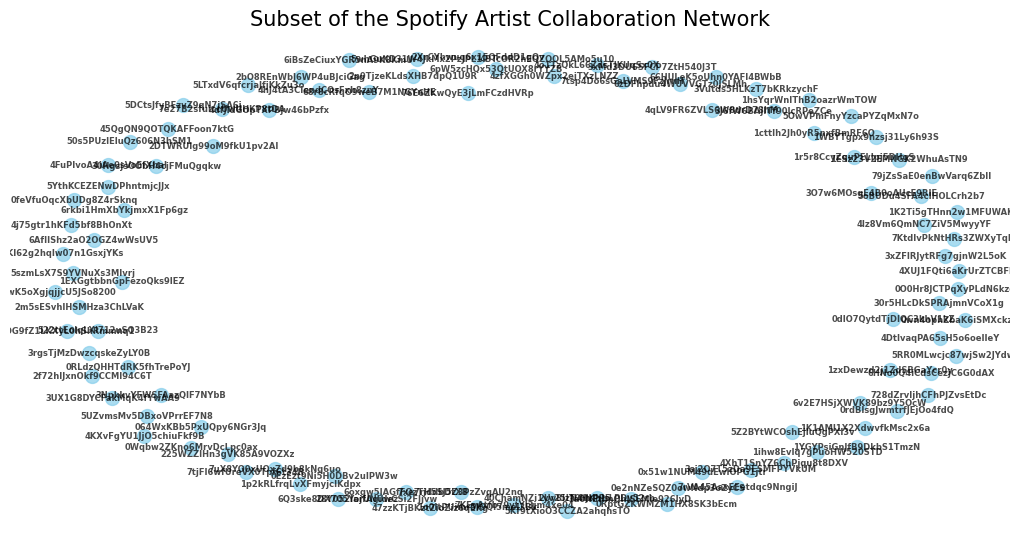

In [60]:
import matplotlib.pyplot as plt
import random
import networkx as nx

# Convert G.nodes() to a list before using random.sample()
nodes_to_visualize = random.sample(list(G.nodes()), 100)

# Create a subgraph with the selected nodes
subgraph = G.subgraph(nodes_to_visualize)

# Use a different layout (spring_layout for example)
layout = nx.spring_layout(subgraph, seed=42)
 # Plot the subgraph with refined parameters for a smaller, clearer visualization
plt.figure(figsize=(10, 5))  # Make the plot slightly smaller for better visualization
nx.draw(subgraph,
        pos=layout,
        with_labels=True,
        node_color='skyblue',
        node_size=100,  # Smaller node size
        font_size=6,  # Smaller font size
        font_weight='bold',
        edge_color='gray',
        width=0.5,  # Thinner edges
        alpha=0.7,
        arrows=True)  # Slight transparency for edges
plt.title("Subset of the Spotify Artist Collaboration Network", size=15)
plt.show()


## 4.Compute Network Properties

In [61]:
import networkx as nx
import random
import pandas as pd

# Create a mapping from node ID to artist name
node_id_to_name = pd.Series(nodes_pd['name'].values, index=nodes_pd['spotify_id']).to_dict()

# Sample 10000 nodes to reduce computational load
num_nodes_to_sample = 10000
sampled_nodes = random.sample(list(G.nodes), min(num_nodes_to_sample, len(G.nodes)))

# Create a subgraph with those nodes
sampled_subgraph = G.subgraph(sampled_nodes).copy()

# Compute centrality measures for each node in the subgraph
degree_centrality = nx.degree_centrality(sampled_subgraph)

betweenness_centrality = nx.betweenness_centrality(sampled_subgraph)

closeness_centrality = nx.closeness_centrality(sampled_subgraph)


try:
    eigenvector_centrality = nx.eigenvector_centrality(sampled_subgraph, max_iter=10000)
except nx.PowerIterationFailedConvergence:
    eigenvector_centrality = {}
    print("⚠️ Eigenvector centrality did not converge.")


pagerank = nx.pagerank(sampled_subgraph)


# Combine all centralities into a DataFrame (optional, helpful for next steps)
centrality_df = pd.DataFrame({
    "Artist Name": [node_id_to_name.get(node, "Unknown") for node in sampled_subgraph.nodes()],
    "Degree Centrality": [degree_centrality.get(node, 0) for node in sampled_subgraph.nodes()],
    "Betweenness Centrality": [betweenness_centrality.get(node, 0) for node in sampled_subgraph.nodes()],
    "Closeness Centrality": [closeness_centrality.get(node, 0) for node in sampled_subgraph.nodes()],
    "Eigenvector Centrality": [eigenvector_centrality.get(node, 0) for node in sampled_subgraph.nodes()],
    "PageRank": [pagerank.get(node, 0) for node in sampled_subgraph.nodes()]
})

# View the first few rows
centrality_df.head()


,Artist Name,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank
0,Rasskulz,0.0002,0.0,0.000225,3.644200e-07,0.000198
1,DaeDae,0.0000,0.0,0.000000,1.182798e-10,0.000090
2,Africanz On Marz,0.0000,0.0,0.000000,1.182798e-10,0.000090
3,Irma,0.0000,0.0,0.000000,1.182798e-10,0.000090
4,Matthildur,0.0000,0.0,0.000000,1.182798e-10,0.000090


In [64]:
# Function to print top 5 most influential artists by any centrality measure
def print_top_5(centrality_dict, measure_name):
    print(f"\n🔝 Top 5 Artists by {measure_name}:")
    top_5 = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:5]
    for node_id, score in top_5:
        name = node_id_to_name.get(node_id, "Unknown")
        print(f"{name}: {score:.5f}")

# Display top 5 artists for each centrality measure
print_top_5(degree_centrality, "Degree Centrality")
print_top_5(betweenness_centrality, "Betweenness Centrality")
print_top_5(closeness_centrality, "Closeness Centrality")
print_top_5(eigenvector_centrality, "Eigenvector Centrality")
print_top_5(pagerank, "PageRank")



🔝 Top 5 Artists by Degree Centrality:
Johann Sebastian Bach: 0.01080
Jean Sibelius: 0.00400
Dimitri Vegas & Like Mike: 0.00160
Arijit Singh: 0.00150
Mc Danny: 0.00130

🔝 Top 5 Artists by Betweenness Centrality:
Johann Sebastian Bach: 0.00002
Drake: 0.00000
Gunna: 0.00000
Wizkid: 0.00000
Arijit Singh: 0.00000

🔝 Top 5 Artists by Closeness Centrality:
Johann Sebastian Bach: 0.00820
Jean Sibelius: 0.00500
Bram van Sambeek: 0.00418
Maurizio Baglini: 0.00418
Alice Harnoncourt: 0.00418

🔝 Top 5 Artists by Eigenvector Centrality:
Headie One: 0.57224
Joey B: 0.56835
Juls: 0.56835
Jory Boy: 0.05173
Benny Benni: 0.05172

🔝 Top 5 Artists by PageRank:
Johann Sebastian Bach: 0.00614
Jean Sibelius: 0.00323
Lisa Batiashvili: 0.00258
Lil Jon: 0.00177
Dimitri Vegas & Like Mike: 0.00158


In [65]:
# Number of nodes and edges in the subgraph
num_nodes = sampled_subgraph.number_of_nodes()
num_edges = sampled_subgraph.number_of_edges()

# Average degree formula
average_degree = (2 * num_edges) / num_nodes

print(f"🔢 Number of nodes: {num_nodes}")
print(f"🔗 Number of edges: {num_edges}")
print(f"📊 Average degree: {average_degree:.2f}")


🔢 Number of nodes: 10000
🔗 Number of edges: 1281
📊 Average degree: 0.26


In [66]:
# Convert the sampled subgraph to undirected
undirected_subgraph = sampled_subgraph.to_undirected()

# Get connected components
connected_components = list(nx.connected_components(undirected_subgraph))

# Identify the largest connected component (LCC)
largest_cc = max(connected_components, key=len)

# Create a subgraph of the LCC
lcc_subgraph = undirected_subgraph.subgraph(largest_cc).copy()

# Compute the diameter
diameter = nx.diameter(lcc_subgraph)

print(f"📏 Diameter of the Largest Connected Component: {diameter}")


📏 Diameter of the Largest Connected Component: 20


## 5.Predicting User Popularity Using PySpark

In [54]:
import os
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CentralityRegression") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1") \
    .config("spark.cores.max", "2") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()

# Convert pandas DataFrame to Spark DataFrame
centrality_df_spark = spark.createDataFrame(centrality_df)

# Rename columns for ML pipeline
centrality_df_spark = centrality_df_spark.selectExpr(
    "`Artist Name` as artist_name",
    "`Degree Centrality` as degree_centrality",
    "`Betweenness Centrality` as betweenness_centrality",
    "`Closeness Centrality` as closeness_centrality",
    "`Eigenvector Centrality` as eigenvector_centrality",
    "`PageRank` as pagerank",
    "`Followers` as followers"
)

# Define features and target (label)
feature_columns = [
    'degree_centrality',
    'betweenness_centrality',
    'closeness_centrality',
    'eigenvector_centrality',
    'pagerank'
]
label_column = 'followers'

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split data into training and testing sets
train_data, test_data = centrality_df_spark.randomSplit([0.8, 0.2], seed=1234)

# Define Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol=label_column)

# Create ML pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Train the model
model = pipeline.fit(train_data)

# Predict on test data
predictions = model.transform(test_data)

# Display prediction results
predictions.select('artist_name', 'followers', 'prediction').show(10, truncate=False)

# Evaluate model performance
evaluator = RegressionEvaluator(
    predictionCol='prediction',
    labelCol=label_column,
    metricName='rmse'
)
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')


+--------------------------+---------+----------------+
|artist_name               |followers|prediction      |
+--------------------------+---------+----------------+
|"Craig ""Groove"" Stevens"|35582    |50174.2270655171|
|"Jon ""Hands-On"" Hanson" |13048    |50174.2270655171|
|100k Track                |8727     |50174.2270655171|
|12TilDee                  |43627    |50174.2270655171|
|19HUNNID                  |55244    |50174.2270655171|
|1Kyne                     |16308    |50174.2270655171|
|1ODUM DEFECT              |4367     |50174.2270655171|
|34bit                     |54908    |50174.2270655171|
|7 Sky Project             |41563    |50174.2270655171|
|8                         |48720    |50174.2270655171|
+--------------------------+---------+----------------+
only showing top 10 rows

Root Mean Squared Error (RMSE): 28715.411890418305


In [55]:
print(f"Number of training observations: {train_data.count()}")
print(f"Number of testing observations: {test_data.count()}")

Number of training observations: 8015
Number of testing observations: 1985


In [67]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Features and target column names exactly as in your Spark DataFrame
feature_columns = [
    "degree_centrality",
    "betweenness_centrality",
    "closeness_centrality",
    "eigenvector_centrality",
    "pagerank"
]
target_column = "followers"

# VectorAssembler to combine features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define Linear Regression model
lr_model = LinearRegression(featuresCol="features", labelCol=target_column)

# Create pipeline with assembler and regression model
pipeline = Pipeline(stages=[assembler, lr_model])

# Train-test split (assuming df_cleaned is your Spark DataFrame)
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=1234)

# Fit pipeline to training data
lr_pipeline_model = pipeline.fit(train_data)

# Extract the trained LinearRegressionModel (last stage of pipeline)
lr_trained_model = lr_pipeline_model.stages[-1]

# Print coefficients and intercept
print("\nLinear Regression Model Coefficients:")
for coef, feat in zip(lr_trained_model.coefficients, feature_columns):
    print(f"{feat:25s}: {coef:.6f}")

print(f"\nIntercept: {lr_trained_model.intercept:.6f}")




Linear Regression Model Coefficients:
degree_centrality        : 2693380.628020
betweenness_centrality   : 5730572310.600779
closeness_centrality     : -21379030.208772
eigenvector_centrality   : -41036.183686
pagerank                 : 31204905.625250

Intercept: 47333.653395


In [57]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluators
evaluator_rmse = RegressionEvaluator(
    labelCol='followers',
    predictionCol='prediction',
    metricName='rmse'
)

evaluator_r2 = RegressionEvaluator(
    labelCol='followers',
    predictionCol='prediction',
    metricName='r2'
)

# Evaluate
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

# Output
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Root Mean Squared Error (RMSE): 28715.4119
R-squared (R²): -0.0012


## 6.	Cluster Users Based on Their Characteristics Using PySpark

In [84]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Assuming you already have centrality_df_spark DataFrame

# Prepare the features (use the same features used in the regression model)
feature_columns = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Define the number of clusters (you can change the number based on your dataset)
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol('features').setPredictionCol('cluster')

# Create a pipeline to combine the feature assembler and KMeans
pipeline = Pipeline(stages=[assembler, kmeans])

# Fit the model
kmeans_model = pipeline.fit(centrality_df_spark)

# Make predictions
predictions = kmeans_model.transform(centrality_df_spark)

# Show predictions (which cluster each user belongs to)
predictions.select("artist_name", "cluster").show()

# Show artists from Cluster 1
print("Artists in Cluster 1:")
predictions.filter(col("cluster") == 1).select("artist_name", "cluster").show(10, truncate=False)

# Show artists from Cluster 2
print("Artists in Cluster 2:")
predictions.filter(col("cluster") == 2).select("artist_name", "cluster").show(10, truncate=False)

# Print the cluster centers (centroids)
centers = kmeans_model.stages[-1].clusterCenters()
print("Cluster Centers:")
for center in centers:
    print(center)


+--------------------+-------+
|         artist_name|cluster|
+--------------------+-------+
|               Maria|      0|
|       Gowry Lekshmi|      0|
|              brassp|      0|
|                 Noa|      0|
|      A Dubb Da Gawd|      0|
|         D-Addiction|      0|
|             Sameera|      0|
|Khairil Johari Johar|      0|
|Legazy Entertainm...|      0|
|         Eyal Barkan|      0|
|      Princess Nokia|      0|
|             Frooker|      0|
|        Soundfactory|      0|
| Abhilipsha Tripathy|      0|
|       Nachttar Gill|      0|
|             Sultana|      0|
|         ItsJustDevv|      0|
|   Friedrich Schüter|      0|
|       Andrews Right|      0|
|               Cäthe|      0|
+--------------------+-------+
only showing top 20 rows

Artists in Cluster 1:
+-----------+-------+
|artist_name|cluster|
+-----------+-------+
|Flashy     |1      |
+-----------+-------+

Artists in Cluster 2:
+-----------+-------+
|artist_name|cluster|
+-----------+-------+
|MNEK    

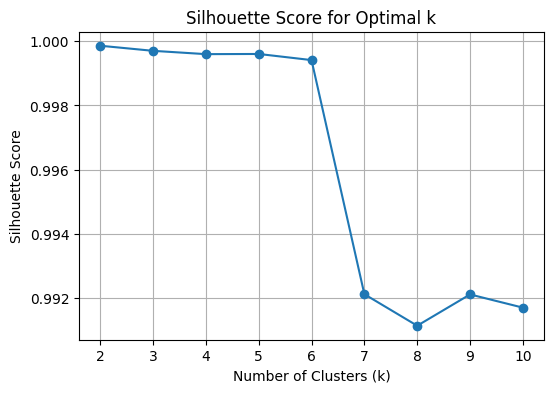

Best k based on silhouette score: 2


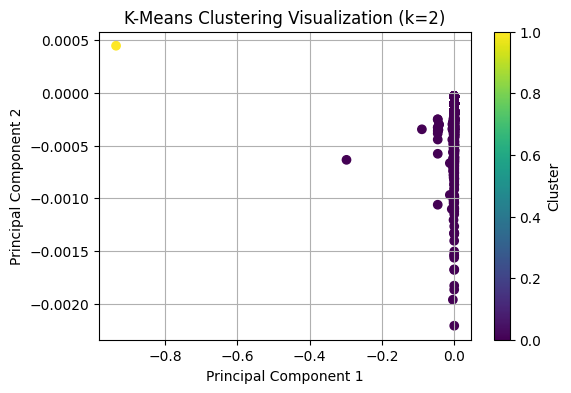

In [79]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Ensure required columns are present and correctly named
required_columns = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality', 'PageRank']
renamed_columns = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']

# Rename columns to lowercase without spaces
for original, new_name in zip(required_columns, renamed_columns):
    user_df_spark = user_df_spark.withColumnRenamed(original, new_name)

# 1. Assemble the features
feature_columns = renamed_columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(user_df_spark)

# 2. Apply KMeans for different values of k
k_range = range(2, 11)
silhouette_scores = []
fitted_models = []

for k in k_range:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features').setPredictionCol('prediction')
    model = kmeans.fit(assembled_df)
    predictions = model.transform(assembled_df)

    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features")
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    fitted_models.append((model, predictions))

# 3. Plot Silhouette Scores
plt.figure(figsize=(6, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# 4. Choose best k (manual or max silhouette score)
best_k_index = silhouette_scores.index(max(silhouette_scores))
best_k = k_range[best_k_index]
best_model, best_predictions = fitted_models[best_k_index]

print(f"Best k based on silhouette score: {best_k}")

# 5. Apply PCA to reduce dimensions for visualization
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(best_predictions)
pca_result = pca_model.transform(best_predictions)

# 6. Convert to Pandas for plotting
pca_pd = pca_result.select("pca_features", "prediction").toPandas()
pca_pd[['PC1', 'PC2']] = pd.DataFrame(pca_pd['pca_features'].tolist(), index=pca_pd.index)

# 7. Plot clusters in 2D
plt.figure(figsize=(6, 4))
plt.scatter(pca_pd['PC1'], pca_pd['PC2'], c=pca_pd['prediction'], cmap='viridis', marker='o')
plt.title(f'K-Means Clustering Visualization (k={best_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()
